## Init

In [1]:
#!module load pytorch-gpu/py3/1.10.0
#!nvidia-smi -L

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import modellib
import datalib
import training
import conf
from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data 

In [180]:
training_dataset = datalib.SimulationBatch.load()

In [181]:
simulation = datalib.SimulationBatch.load_simulation(
    "CM65Work-Spinup-Ref-noleap_18600101_18691231_1M_MSFT.nc",
    "CM65Work-Spinup-Ref-noleap_18700101_18791231_1M_MSFT.nc",
    "CM65Work-Spinup-Ref-noleap_18800101_18891231_1M_MSFT.nc",
    "CM65Work-Spinup-Ref-noleap_18900101_18991231_1M_MSFT.nc",
    "CM65Work-Spinup-Ref-noleap_19000101_19091231_1M_MSFT.nc",
    "CM65Work-Spinup-Ref-noleap_19100101_19191231_1M_MSFT.nc",
    "CM65Work-Spinup-Ref-noleap_19200101_19291231_1M_MSFT.nc",
    "CM65Work-Spinup-Ref-noleap_19300101_19391231_1M_MSFT.nc",
    "CM65Work-Spinup-Ref-noleap_19400101_19491231_1M_MSFT.nc",
    prefix="/gpfswork/rech/omr/commun/CM65Work-Spinup-Ref-noleap-MSFT/"
)
test_dataset = datalib.SimulationBatch([simulation])

In [182]:
len(training_dataset.simulations), training_dataset.simulations[0].shape, len(test_dataset.simulations), test_dataset.simulations[0].shape

(3, (2880, 331, 360), 1, (1080, 331, 360))

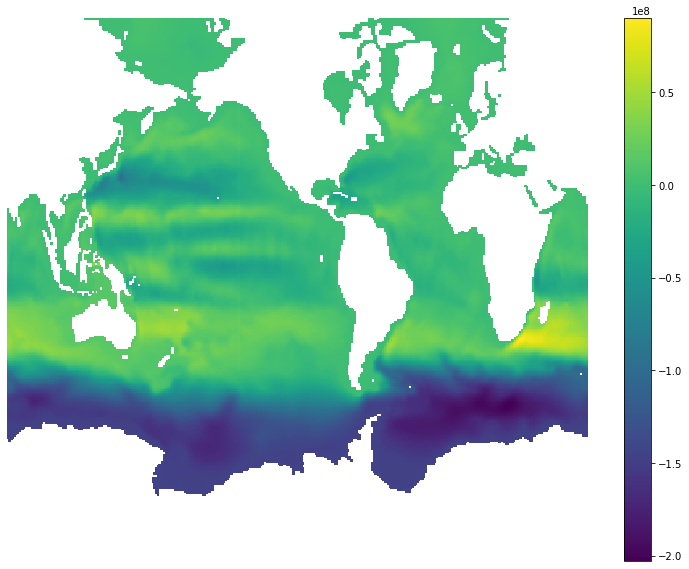

In [183]:
plt.figure(figsize=(13, 10)) ; plt.pcolor(training_dataset[0][10]) ; plt.colorbar() ; plt.axis('off') ; plt.show()

## Data conversion

Remove annual cycles, average annually, infer mask, etc.

In [184]:
def prepare(dataset, *args):
    # dataset.convert2ssca()
    dataset.convert2annual()
    dataset.infer_mask()
    dataset.normalize(*args, method="pointwise_stats")
    dataset.apply_mask()
    return dataset.m.squeeze(), dataset.std.squeeze()

m, std = prepare(training_dataset)
print(m, std)

-30855864.0 57894744.0


## PCA 

In [185]:
pca = training_dataset.compute_pca(200, transform=False)

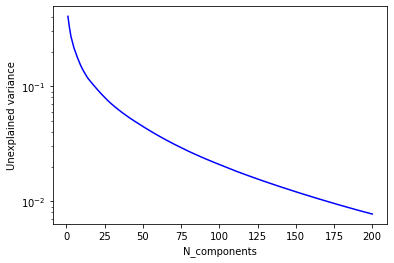

In [186]:
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 1 - np.cumsum(pca.explained_variance_ratio_), "b-")
plt.yscale("log")
plt.ylabel("Unexplained variance")
plt.xlabel("N_components")
plt.show()

In [187]:
pca = training_dataset.compute_pca(1, transform=True)
training_dataset.to_torch()
[(sim.shape, sim.dtype) for sim in training_dataset], [(sim.shape, sim.dtype) for sim in training_dataset.masked_simulations]

([((240, 331, 360), dtype('float32')),
  ((600, 331, 360), dtype('float32')),
  ((240, 331, 360), dtype('float32'))],
 [(torch.Size([240, 1]), torch.float32),
  (torch.Size([600, 1]), torch.float32),
  (torch.Size([240, 1]), torch.float32)])

## Convert test dataset 

In [188]:
prepare(test_dataset, m, std)

(array(-30855864., dtype=float32), array(57894744., dtype=float32))

## GAUSSIAN PROCESS

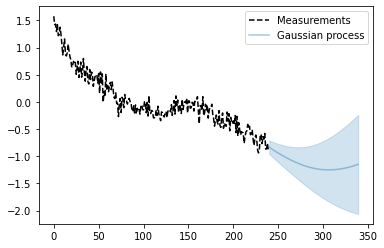

In [189]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

def define_gaussian_process():
    long_term_trend_kernel = 50.0**2 * RBF(length_scale=100.0)
    irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=5.0, alpha=1.0)
    noise_kernel = 0.1**2 * RBF(length_scale=0.01) + WhiteKernel(
        noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
    )
    kernel = long_term_trend_kernel + irregularities_kernel + noise_kernel
    
    return GaussianProcessRegressor(kernel=kernel, normalize_y=False)

def show_GP_result(signal, X_test, mean_y_pred, std_y_pred):
    plt.plot(np.arange(len(signal)), signal, color="black", linestyle="dashed", label="Measurements")
    plt.plot(X_test[:, 0], mean_y_pred[:], color="tab:blue", alpha=0.4, label="Gaussian process")
    plt.fill_between(
        X_test[:, 0],
        mean_y_pred[:] - std_y_pred,
        mean_y_pred[:] + std_y_pred,
        color="tab:blue",
        alpha=0.2,
    )
    plt.legend()
    plt.show()

def predict_with_gaussian_process(signal, steps=10, show=False):
    gaussian_process = define_gaussian_process()
    gaussian_process.fit(np.arange(len(signal)).reshape(-1, 1), signal)
    X_test = np.arange(len(signal), len(signal) + steps).reshape(-1, 1)    
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    if show:
        show_GP_result(signal, X_test, mean_y_pred, std_y_pred)
    return mean_y_pred

X_pred = predict_with_gaussian_process(
    signal=training_dataset.masked_simulations[0][:, 0], steps=100, show=True
)

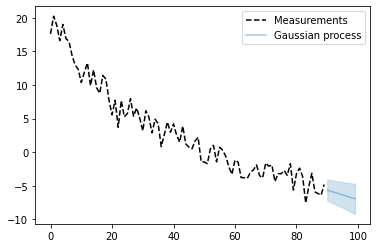

In [190]:
X_input = pca.transform(test_dataset.masked_simulations[0])
X_pred = predict_with_gaussian_process(signal=X_input[:, 0], steps=10, show=True)

(1,)


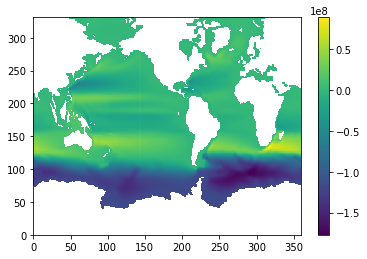

In [191]:
def regen_new_map_from_regression(X_input, X_pred, pca, m, std):
    last_point = np.concatenate([X_pred[-1:], X_input[-1, 1:]], axis=0)
    print(last_point.shape)
    map_ = pca.inverse_transform(last_point)
    map_ = np.zeros((331, 360), dtype=float)
    bool_mask = training_dataset.bool_mask.cpu().numpy()
    map_[bool_mask] = pca.inverse_transform(last_point)
    map_[~bool_mask] = np.nan
    map_ = 2 * map_ * std + m
    return map_

map_ = regen_new_map_from_regression(X_input, X_pred, pca, m, std)
plt.pcolor(map_)
plt.colorbar()
plt.show()

In [192]:
with open("CM65Work-Spinup-Ref-noleap__1950_1960_1modes.npy", "wb") as file_:
    np.save(file_, map_)